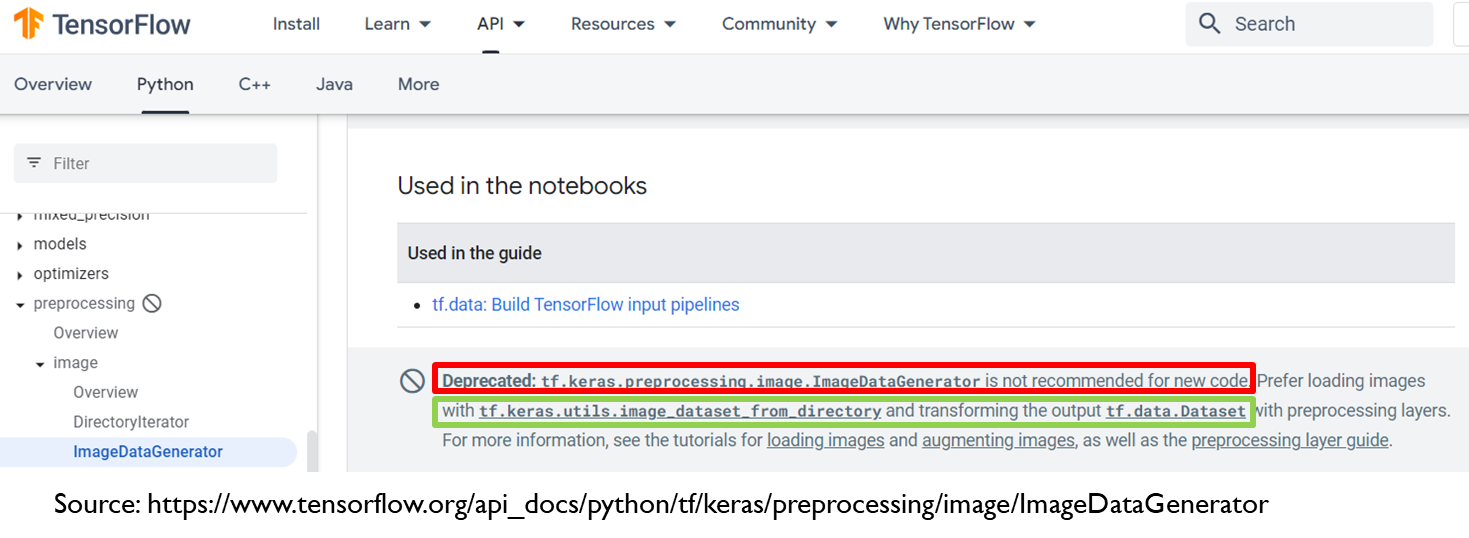

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, adjusted_rand_score, silhouette_score
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn import preprocessing
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom


from keras.optimizers import Adam, SGD


from PIL import Image
Image.MAX_IMAGE_PIXELS = None
# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from keras.optimizers import RMSprop
#from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.callbacks import LearningRateScheduler

import random
import time
import cv2
from tqdm import tqdm

Num GPUs Available:  0


In [20]:
image_folder = "./Flipkart/Images/"
# Load CSV into Pandas DataFrame
text_data_path = r'./Flipkart/flipkart_com-ecommerce_sample_1050.csv'
df = pd.read_csv(text_data_path)
df.sample(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
1004,6325bf868b9040a0599f257aba42e9e0,2016-03-03 11:29:08 +0000,http://www.flipkart.com/doraemon-gift-family-c...,Doraemon Gift Family Ceramic Coffee Mug Multic...,"[""Baby Care >> Baby & Kids Gifts >> Decoration...",DECEG7K7Y3URGWXH,399.0,280.0,6325bf868b9040a0599f257aba42e9e0.jpg,False,Specifications of Doraemon Gift Family Ceramic...,No rating available,No rating available,Doraemon Gift Family Ceramic Coffee Mug,"{""product_specification""=>[{""key""=>""Sales Pack..."
219,2ede595489db33a036d135ce22645515,2015-12-01 12:40:44 +0000,http://www.flipkart.com/mcb-exports-mini-6-dra...,MCB Exports Mini 6 Drawer Chest Showpiece - ...,"[""Home Decor & Festive Needs >> Showpieces >> ...",SHIEBYA7DVARZBKB,4999.0,4699.0,2ede595489db33a036d135ce22645515.jpg,False,MCB Exports Mini 6 Drawer Chest Showpiece - ...,No rating available,No rating available,MCB Exports,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
516,d77279c8268e231b685cdbaf299e83f2,2016-01-07 05:50:25 +0000,http://www.flipkart.com/sonata-7016ym09-watch/...,Sonata 7016YM09 Watch,"[""Watches >> Wrist Watches >> Sonata Wrist Wat...",WATDZ2ZQK6VS9DB4,968.0,968.0,d77279c8268e231b685cdbaf299e83f2.jpg,False,Sonata 7016YM09 Watch - Buy Sonata 7016YM09 Wa...,No rating available,No rating available,NaN,"{""product_specification""=>{""key""=>""Style Code""..."
330,394c2c627914e1eed9b8ac343583a679,2015-12-01 06:13:00 +0000,http://www.flipkart.com/asus-rt-n12-lx-300mbps...,Asus RT-N12 LX 300Mbps Wireless Router,"[""Computers >> Network Components >> Routers >...",RTRD6352VX7RZSWG,3950.0,1990.0,394c2c627914e1eed9b8ac343583a679.jpg,False,Buy Asus RT-N12 LX 300Mbps Wireless Router onl...,4.1,4.1,Asus,"{""product_specification""=>[{""key""=>""Firewall"",..."
352,833a87b0af3b84fe246d2ebf271af177,2015-12-01 06:13:00 +0000,http://www.flipkart.com/zyxel-pla-4205/p/itmdy...,Zyxel PLA-4205,"[""Computers >> Network Components >> Routers >...",RTRDYZYDXGHXXJNZ,10999.0,8100.0,833a87b0af3b84fe246d2ebf271af177.jpg,False,Buy Zyxel PLA-4205 only for Rs. 8100 from Flip...,No rating available,No rating available,Zyxel,"{""product_specification""=>[{""key""=>""In The Box..."


In [21]:
# Split the product_category_tree column into subcategory columns and keep only the 2 first catagory levels
category_lables = df['product_category_tree'].str.split(' >> ', expand=True).iloc[:, :2][0]

# Remove square brackets and double quotes from all strings in the DataFrame
df['category'] = category_lables.apply(lambda x: str(x).replace('[', '').replace('"', '').replace(']', ''))
list_categories = df['category'].unique().tolist()
df['category']


le = preprocessing.LabelEncoder()
le.fit(df["category"])
df['category_encoded'] = le.transform(df["category"])
category_dict = dict(zip(df['category'], df['category_encoded']))
category_dict

{'Home Furnishing': 4,
 'Baby Care': 0,
 'Watches': 6,
 'Home Decor & Festive Needs': 3,
 'Kitchen & Dining': 5,
 'Beauty and Personal Care': 1,
 'Computers': 2}

# Utility functions

* Metrics

In [22]:
def calculate_ari(labels_true, labels_pred):
    ari = np.round(adjusted_rand_score(labels_true, labels_pred), 2)
    return ari

def calculate_silhouette_score(data, labels):
    silhouette = np.round(silhouette_score(data, labels), 2)
    return silhouette

In [23]:
def conf_mat_transform2(y_true,y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print(type(corresp))
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    if not np.array_equal(corresp, np.array([0, 1, 2, 3, 4, 5, 6])):
        labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
        return labels['y_pred_transform'], corresp
    else:
        return labels['y_pred'], corresp

In [24]:
def create_model_fct(model, n_class, dropout_rate, optimization='rmsprop'):

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(n_class, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer=optimization, metrics=["accuracy"])

    print(model.summary())
    
    return model

In [25]:
batch_size = 64

In [26]:
def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='category',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

## New approach using Dataset with integrated data augmentation

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [27]:
def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [28]:
# n order to shuffle the images, initially sorted by class.
df_data_aug = df.copy()
df_data_aug['image_path'] = df_data_aug['image'].apply(lambda x: glob(os.path.join(image_folder, x))[0])
df_data_aug.image_path

df_aug_dev, df_aug_test = train_test_split(df_data_aug, test_size=0.15)
df_aug_dev_train, df_aug_dev_val = train_test_split(df_aug_dev, test_size=0.176)

df_aug_dev_train.shape, df_aug_dev_val.shape, df_aug_test.shape

((735, 18), (157, 18), (158, 18))

In [29]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label



In [30]:
def image_prep_fct(data):
    prepared_images = []  # List to store prepared images
    for image_num in range(data.shape[0]):
        # Load image, resize to (224, 224), and convert to NumPy array
        img = load_img(glob(os.path.join(image_folder, data['image'].tolist()[image_num]))[0],
                       target_size=(224, 224))
        img = img_to_array(img)

        # Reshape the array to match the expected input shape
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))

        # Preprocess the image according to the requirements of the VGG16 model
        img = preprocess_input(img)

        # Append the prepared image to the list
        prepared_images.append(img)

    # Convert the list of prepared images to a NumPy array
    prepared_images_np = np.array(prepared_images)
    
    return prepared_images_np

In [31]:
def create_model_fct2(n_class=7) :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Pre-trained model
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # New model definition
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(n_class, activation='softmax')
                ])

    # Model compilation
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [32]:
# New model
new_model = create_model_fct2()

# Création du callback
new_model_save_path = "./new_model_best_weights.h5"
checkpoint = ModelCheckpoint(new_model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                      

In [33]:
df_aug_dev_train.shape, df_aug_dev_val.shape, df_aug_test.shape

((735, 18), (157, 18), (158, 18))

In [34]:
# images from training
images_aug_dev_train = image_prep_fct(df_aug_dev_train)
print(images_aug_dev_train.shape)
# images from the validation
images_aug_dev_val= image_prep_fct(df_aug_dev_val)
print(images_aug_dev_val.shape)
# images from test
images_aug_test= image_prep_fct(df_aug_test)
print(images_aug_test.shape)

(735, 224, 224, 3)
(157, 224, 224, 3)
(158, 224, 224, 3)


In [35]:
X_aug_dev_train = images_aug_dev_train
y_aug_dev_train = to_categorical(df_aug_dev_train['category_encoded'])
print(X_aug_dev_train.shape, y_aug_dev_train.shape)

X_aug_dev_val= images_aug_dev_val
y_aug_dev_val= to_categorical(df_aug_dev_val['category_encoded'])
print(X_aug_dev_val.shape, y_aug_dev_val.shape)

X_aug_test = images_aug_test
y_aug_test = to_categorical(df_aug_test['category_encoded'])
print(X_aug_test.shape, y_aug_test.shape)


(735, 224, 224, 3) (735, 7)
(157, 224, 224, 3) (157, 7)
(158, 224, 224, 3) (158, 7)


In [36]:
history = new_model.fit(X_aug_dev_train, y_aug_dev_train,
                    validation_data=(X_aug_dev_val, y_aug_dev_val),
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50


12/12 [==============================] - ETA: 0s - loss: 1.9377 - accuracy: 0.2463 
Epoch 1: val_loss improved from inf to 1.50189, saving model to .\new_model_best_weights.h5
12/12 [==============================] - 235s 19s/step - loss: 1.9377 - accuracy: 0.2463 - val_loss: 1.5019 - val_accuracy: 0.5987
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 1.5263 - accuracy: 0.4680 
Epoch 2: val_loss improved from 1.50189 to 1.17468, saving model to .\new_model_best_weights.h5
12/12 [==============================] - 199s 17s/step - loss: 1.5263 - accuracy: 0.4680 - val_loss: 1.1747 - val_accuracy: 0.6879
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 1.2562 - accuracy: 0.5986 
Epoch 3: val_loss improved from 1.17468 to 0.97022, saving model to .\new_model_best_weights.h5
12/12 [==============================] - 186s 16s/step - loss: 1.2562 - accuracy: 0.5986 - val_loss: 0.9702 - val_accuracy: 0.7580
Epoch 4/50
12/12 [==============================]

In [37]:
# Score du dernier epoch

loss_train, accuracy_train = new_model.evaluate(X_aug_dev_train, y_aug_dev_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy_train))
print()
loss_val, accuracy_val = new_model.evaluate(X_aug_dev_val, y_aug_dev_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy_val))

23/23 [==============================] - 203s 9s/step - loss: 0.2630 - accuracy: 0.9156
Training Accuracy   : 0.9156

5/5 [==============================] - 31s 6s/step - loss: 0.5339 - accuracy: 0.8344
Validation Accuracy :  0.8344


In [40]:
loss_test, accuracy_test = new_model.evaluate(X_aug_test, y_aug_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test))

Test Accuracy       :  0.8101


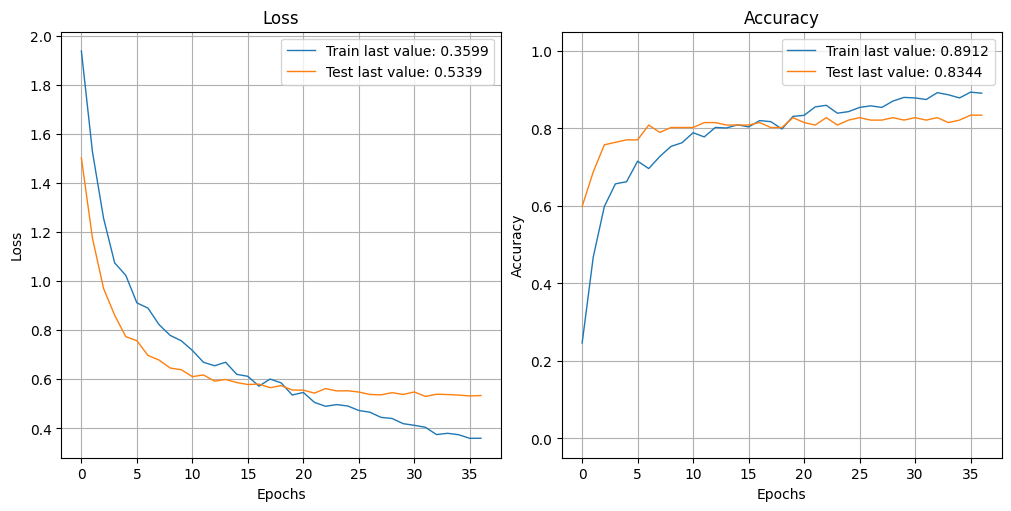

In [41]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history)
plot_history(history, path="standard.png")
plt.close()